## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

In [2]:
from random import sample
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import math

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
108317,00029350_000.png,No Finding,0,29350,65,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00029350_000.png
58569,00014485_000.png,No Finding,0,14485,37,M,PA,2890,2922,0.143000,0.143000,NaN,/data/images_007/images/00014485_000.png
53337,00013469_000.png,No Finding,0,13469,31,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_006/images/00013469_000.png


In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

findings = set()
for f in all_xray_df['Finding Labels'].unique():
    findings.update(f.split('|'))
print(f'Total number of single diagnoses: {len(findings)}')
findings

Total number of single diagnoses: 15


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

In [6]:
for finding in findings:
    all_xray_df[finding] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)

all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Nodule,Consolidation,Pleural_Thickening,Emphysema,Edema,Hernia,Fibrosis,Atelectasis,Effusion
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: 'Y' if x['Pneumonia'] == 1.0 else 'N', axis=1)
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Nodule,Consolidation,Pleural_Thickening,Emphysema,Edema,Hernia,Fibrosis,Atelectasis,Effusion,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,N
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,N


## Create your training and testing data:

In [8]:
def create_splits(**vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    df = vargs['df']
    
    train_df, valid_df = skl.train_test_split(df, test_size = 0.2, stratify = df['pneumonia_class'])
    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Initial split. Train set pneumonia: {100.0*train_df_ratio :.2f}%. Valid set pneumonia: {100.0*valid_df_ratio :.2f}%')
    
    # make training set contain same number of positive and negative cases
    train_pos_inds = train_df[train_df['pneumonia_class'] == 'Y'].index.tolist()
    train_neg_inds = train_df[train_df['pneumonia_class'] == 'N'].index.tolist()

    train_neg_sample = sample(train_neg_inds, len(train_pos_inds))
    train_df = train_df.loc[train_pos_inds + train_neg_sample]

    train_df_ratio = len(train_df[train_df['pneumonia_class'] == 'Y'])/len(train_df)
    print(f'Train set corrected (50/50), pneumonia: {100.0*train_df_ratio :.2f}%')
    
    # make validation set contain 80% positive and 20% negative cases
    valid_pos_inds = valid_df[valid_df['pneumonia_class'] == 'Y'].index.tolist()
    valid_neg_inds = valid_df[valid_df['pneumonia_class'] == 'N'].index.tolist()

    valid_neg_sample = sample(valid_neg_inds, 4*len(valid_pos_inds))
    valid_df = valid_df.loc[valid_pos_inds + valid_neg_sample]

    valid_df_ratio = len(valid_df[valid_df['pneumonia_class'] == 'Y'])/len(valid_df)
    print(f'Valid set corrected (20/80), pneumonia: {100.0*valid_df_ratio :.2f}%')

    return train_df, valid_df

In [9]:
df_train, df_valid = create_splits(df = all_xray_df)
print(f'Train set size: {len(df_train)}, valid set size: {len(df_valid)}')

Initial split. Train set pneumonia: 1.28%. Valid set pneumonia: 1.28%
Train set corrected (50/50), pneumonia: 50.00%
Valid set corrected (20/80), pneumonia: 20.00%
Train set size: 2290, valid set size: 1430


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
# most common image size used for augmentation
IMAGE_SIZE = (224, 224)

def my_image_augmentation_train(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    rotation = vargs['rotation'] if 'rotation' in vargs else 20
    shear = vargs['shear'] if 'shear' in vargs else 0.1
    zoom = vargs['zoom'] if 'rotation' in vargs else 0.1
    
    gen = ImageDataGenerator(
        rescale=1. / 255.0, 
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range = 0.1, 
        width_shift_range = 0.1, 
        rotation_range = rotation, 
        shear_range = shear,
        zoom_range = zoom)
    
    return gen


def make_train_gen(**vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    df = vargs['df']
    
    aug = my_image_augmentation_train(**vargs)
    
    train_gen = aug.flow_from_dataframe(
        dataframe = df, 
        directory = None, 
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMAGE_SIZE, 
        batch_size = 32)

    return train_gen


def my_image_augmentation_valid(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
#     rotation = vargs['rotation'] if 'rotation' in vargs else 20
#     shear = vargs['shear'] if 'shear' in vargs else 0.1
#     zoom = vargs['zoom'] if 'rotation' in vargs else 0.1
    
    gen = ImageDataGenerator(rescale=1. / 255.0)
    
    return gen

def make_valid_gen(**vargs):

    df = vargs['df']
    
    aug = my_image_augmentation_valid(**vargs)
    
    valid_gen = aug.flow_from_dataframe(
        dataframe = df, 
        directory = None, 
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMAGE_SIZE, 
        batch_size = 1024)
    
    return valid_gen

In [11]:
train_gen = make_train_gen(df = df_train)
valid_gen = make_valid_gen(df = df_valid)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = valid_gen.next()

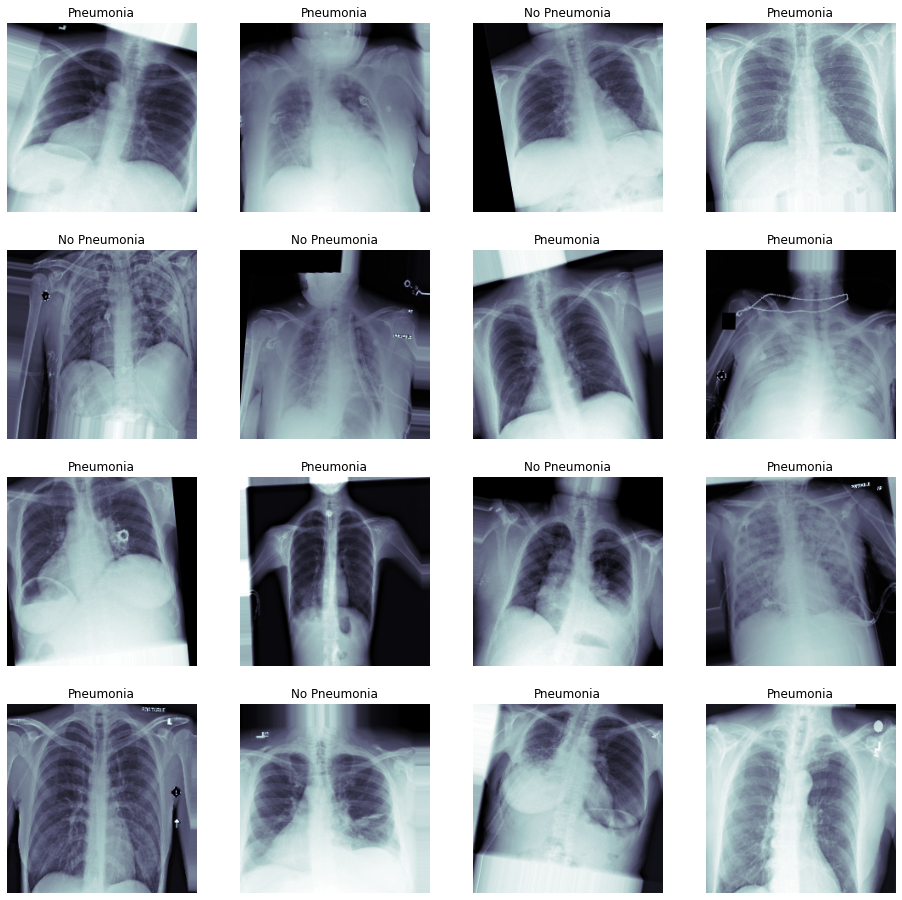

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
    
plt.show()

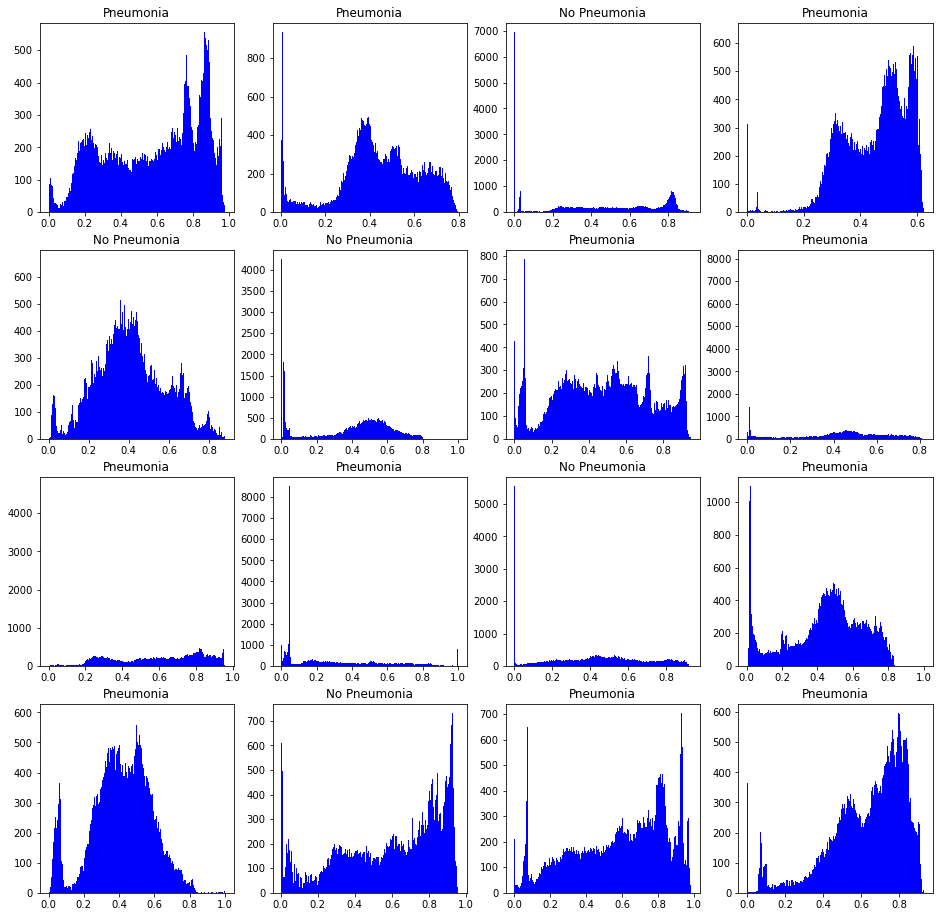

In [14]:
# t_x, t_y = next(train_gen)

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     mask = (data > 0.1) & (data < 0.9)
#     d = data[mask].flatten()
    c_ax.hist(c_x[:,:,0].flatten(), bins = 256, color='blue')
    
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')

plt.show()


## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [15]:
def load_pretrained_model(**vargs):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # trainable
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    print('VGG16 layers:')
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
        
    return vgg_model


In [16]:
def build_my_model(**vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # learning_rate = vargs['learning_rate'] if 'learning_rate' in vargs else 1e-4
    
    vgg_model = load_pretrained_model()
    
    new_model = Sequential()
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    new_model.add(Flatten())
    new_model.add(Dropout(0.2))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.2))
#     new_model.add(Dense(1, activation='relu'))    

    new_model.add(Dense(1, activation='sigmoid'))
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [17]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_model.best.hdf5".format('xray_classification')

# checkpoint = ModelCheckpoint(
#     weight_path, 
#     monitor = CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE
#     verbose = 1, 
#     save_best_only = True, 
#     mode = #CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC
#     save_weights_only = True)

# early = EarlyStopping(
#     monitor = #SAME_AS_METRIC_CHOSEN_ABOVE
#     mode = #CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC
#     patience=5)

# callbacks_list = [checkpoint, early]

In [18]:
model = build_my_model()
model.summary()

553467904/553467096 [==============================] - 6s 0us/step
VGG16 layers:
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)     

### Start training! 

In [ ]:
# define learning rate, loss, metrics and compile
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# define callbacks
weight_path="{}_model.best.hdf5".format('xray_classification')
checkpoint = ModelCheckpoint(weight_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=10)
callbacks_list = [checkpoint, early]

# train your model
history = model.fit_generator(
    train_gen, 
    validation_data = (valX, valY), 
    epochs = 100,
    callbacks = callbacks_list)


Epoch 1/100
72/72 [==============================] - 75s 1s/step - loss: 0.7084 - binary_accuracy: 0.5319 - val_loss: 0.7559 - val_binary_accuracy: 0.3369

Epoch 00001: val_loss improved from inf to 0.75589, saving model to xray_classification_model.best.hdf5
Epoch 2/100
72/72 [==============================] - 60s 827ms/step - loss: 0.7000 - binary_accuracy: 0.5314 - val_loss: 0.6673 - val_binary_accuracy: 0.5977

Epoch 00002: val_loss improved from 0.75589 to 0.66731, saving model to xray_classification_model.best.hdf5
Epoch 3/100
72/72 [==============================] - 60s 833ms/step - loss: 0.6893 - binary_accuracy: 0.5550 - val_loss: 0.7616 - val_binary_accuracy: 0.4189

Epoch 00003: val_loss did not improve from 0.66731
Epoch 4/100
72/72 [==============================] - 60s 827ms/step - loss: 0.6878 - binary_accuracy: 0.5651 - val_loss: 0.6068 - val_binary_accuracy: 0.7012

Epoch 00004: val_loss improved from 0.66731 to 0.60677, saving model to xray_classification_model.best.h

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

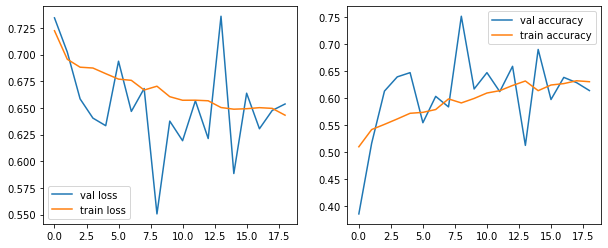

In [35]:
f = plt.figure()
f.set_figwidth(10)
f.add_subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

f.add_subplot(1, 2, 2)
plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
plt.plot(history.history['binary_accuracy'], label='train accuracy')
plt.legend()

plt.show()

#### Predictions

In [36]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1024/1024 [==============================] - 9s 9ms/step


In [37]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')    
    plt.show()

## what other performance statistics do you want to include here besides AUC? 

def plot_pr(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

    
# Also consider plotting the history of your model training:

def plot_history(history):
    return

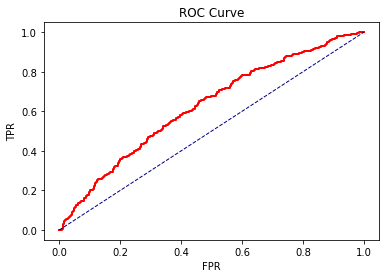

In [38]:
## plot figures
plot_auc(valY, pred_Y)

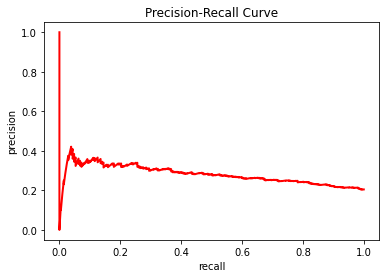

In [39]:
plot_pr(valY, pred_Y)

Text(0.5, 1.0, 'Precision/Recall by threshold')

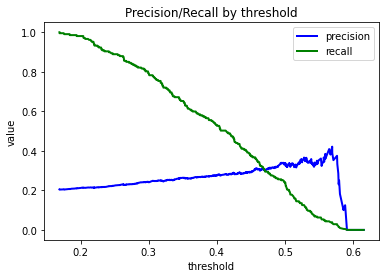

In [40]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)
plt.plot(thresholds, precision[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Precision/Recall by threshold')

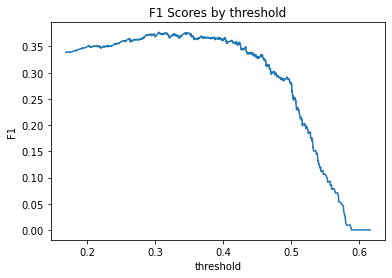

In [41]:
th = 0.5

def f1(threshold):
    for i,t in enumerate(thresholds):
        if t > threshold:
            f1score = calc_f1(precision[i], recall[i])
            if not math.isnan(f1score):
                return f1score
            else: 
                return 0
    return 0

f1scores = [f1(t) for t in thresholds]
plt.plot(thresholds, f1scores)
plt.title('F1 Scores by threshold')
plt.xlabel('threshold')
plt.ylabel('F1')
plt.show()


In [42]:
ind = np.argmax(np.array(f1scores, dtype=np.float32))
f1 = f1scores[ind]
print(f'Max F1 score: {f1 :.3f}, threshold: {thresholds[ind] :.3f}, precision: {precision[ind] :.3f}, recall: {recall[ind] :.3f}')

Max F1 score: 0.377, threshold: 0.306, precision: 0.248, recall: 0.783


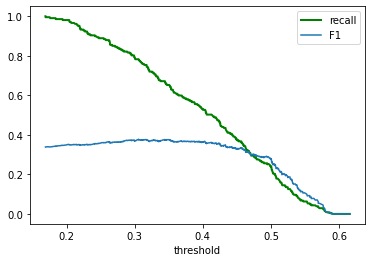

In [43]:
plt.plot(thresholds, recall[:-1], color='green', lw=2, label='recall')
plt.plot(thresholds, f1scores, label='F1')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [44]:
def get_index(th):
    for i,t in enumerate(thresholds):
        if t > th:
            return i

print(f'Recall: {recall[get_index(0.29)] :.3f}, precision: {precision[get_index(0.29)] :.3f}, F1: {f1scores[get_index(0.29)] :.3f}, threshold: {thresholds[get_index(0.29)] :.3f}')
print(f'Recall: {recall[get_index(0.3)] :.3f}, precision: {precision[get_index(0.3)] :.3f}, F1: {f1scores[get_index(0.3)] :.3f}, threshold: {thresholds[get_index(0.3)] :.3f}')
print(f'Recall: {recall[get_index(0.31)] :.3f}, precision: {precision[get_index(0.31)] :.3f}, F1: {f1scores[get_index(0.31)] :.3f}, threshold: {thresholds[get_index(0.31)] :.3f}')
print(f'Recall: {recall[get_index(0.33)] :.3f}, precision: {precision[get_index(0.33)] :.3f}, F1: {f1scores[get_index(0.33)] :.3f}, threshold: {thresholds[get_index(0.33)] :.3f}')
print(f'Recall: {recall[get_index(0.35)] :.3f}, precision: {precision[get_index(0.35)] :.3f}, F1: {f1scores[get_index(0.35)] :.3f}, threshold: {thresholds[get_index(0.35)] :.3f}')

Recall: 0.816, precision: 0.241, F1: 0.372, threshold: 0.290
Recall: 0.792, precision: 0.243, F1: 0.370, threshold: 0.300
Recall: 0.763, precision: 0.247, F1: 0.374, threshold: 0.310
Recall: 0.705, precision: 0.253, F1: 0.373, threshold: 0.330
Recall: 0.652, precision: 0.264, F1: 0.374, threshold: 0.351


In [45]:
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > 0.3).astype(int)).ravel()
tn, fp, fn, tp

(305, 512, 43, 164)

##### As you can see, we can get much higher recall with comparatively very small loss in precision, and F1 score, e.g. for threshold = 0.3
Clearly, this comes at a cost of high number of false positives, but out model generally has low precision.

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [46]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

YOUR_THRESHOLD = 0.3
testY = valY

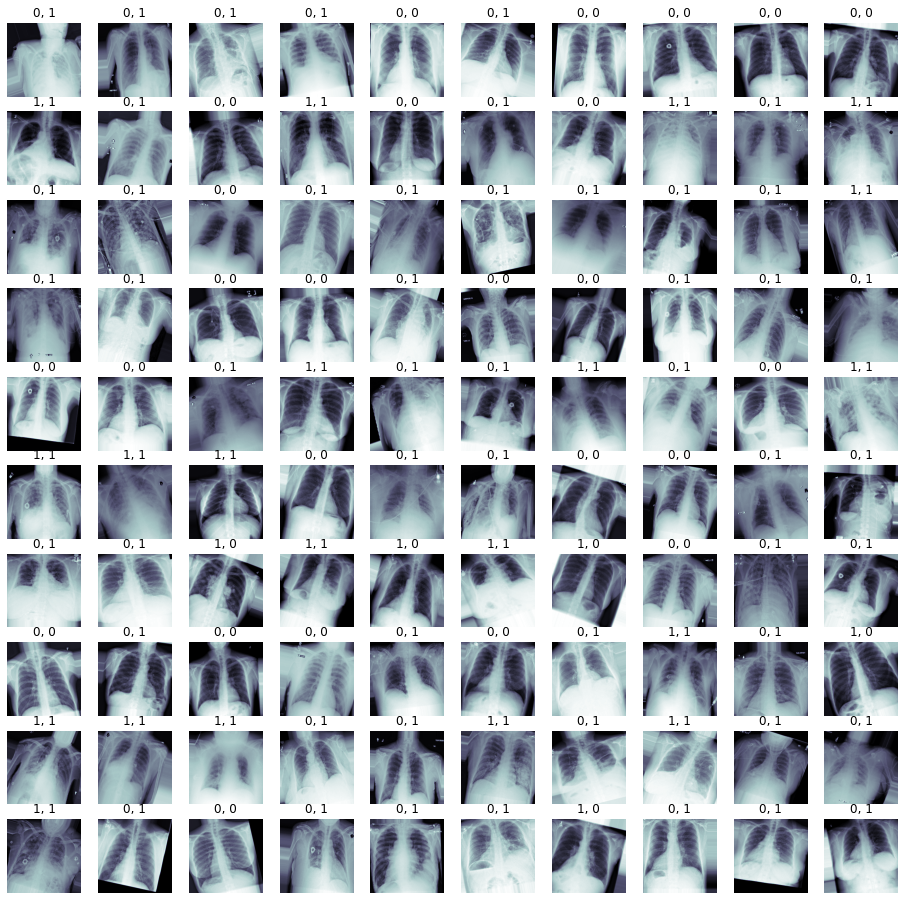

In [47]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

#### As expected, we see large number of false positives, but low number of false negatives

In [48]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("xray_final_model.json", "w") as json_file:
    json_file.write(model_json)

### Summary

* The model has good recall, but very low precision, which will lead to high number of false positives
* Therefore, it should be used only as an assitance to a radiologist, putting to low priority queue those xrays that were classified as negative by the model. The probability of such xrays actually containing pneumonia is 9.56%

#### To make model more useful (future research):
* Remove extreme intensity areas (no light, or too intensive light) from images, or use gaussian blur
* Vary hyper-parameters: 
    * dropout rate
    * augmentation parameters
    * batch size
    * learning rate
* Use additional info from the dataset during training (multi-input architecture)